 Loaded video_summary: (360, 61)
 Loaded audio_summary: (360, 74)
 Loaded combined_summary: (360, 130)

-------------------- VIDEO SUMMARY --------------------
Dataset shape: 360 rows × 61 columns
Total missing values: 0
Overall missing rate: 0.00%
Columns with missing values: 0
 No missing values found!

-------------------- AUDIO SUMMARY --------------------
Dataset shape: 360 rows × 74 columns
Total missing values: 538
Overall missing rate: 2.02%
Columns with missing values: 3

 Columns with missing values:
       Column  Missing_Count  Missing_Percent
     cpp_mean            268            74.44
      cpp_var            268            74.44
shimmer_apq11              2             0.56

-------------------- COMBINED SUMMARY --------------------
Dataset shape: 360 rows × 130 columns
Total missing values: 538
Overall missing rate: 1.15%
Columns with missing values: 3

 Columns with missing values:
       Column  Missing_Count  Missing_Percent
      cpp_var            268            

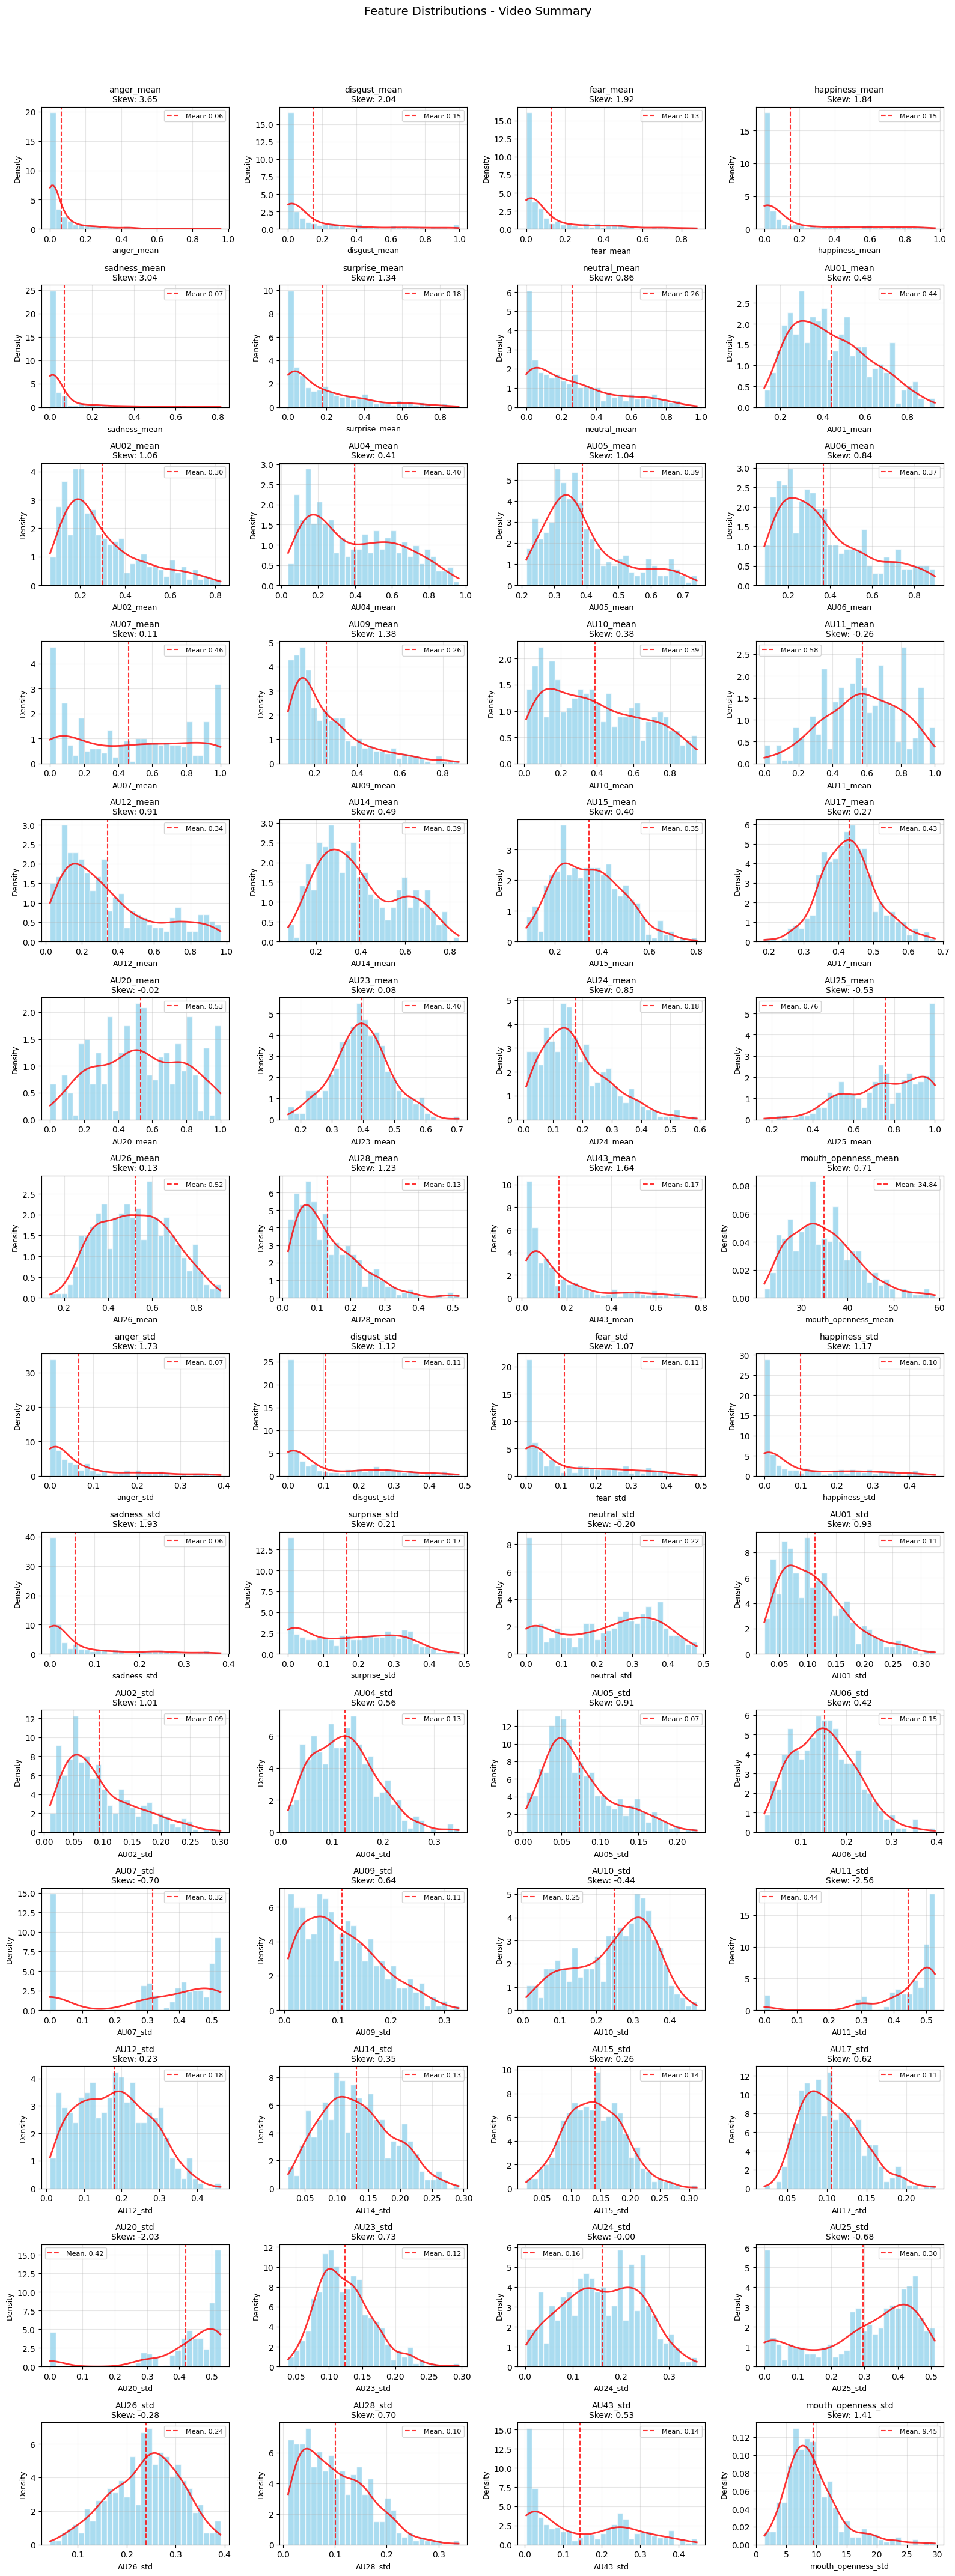

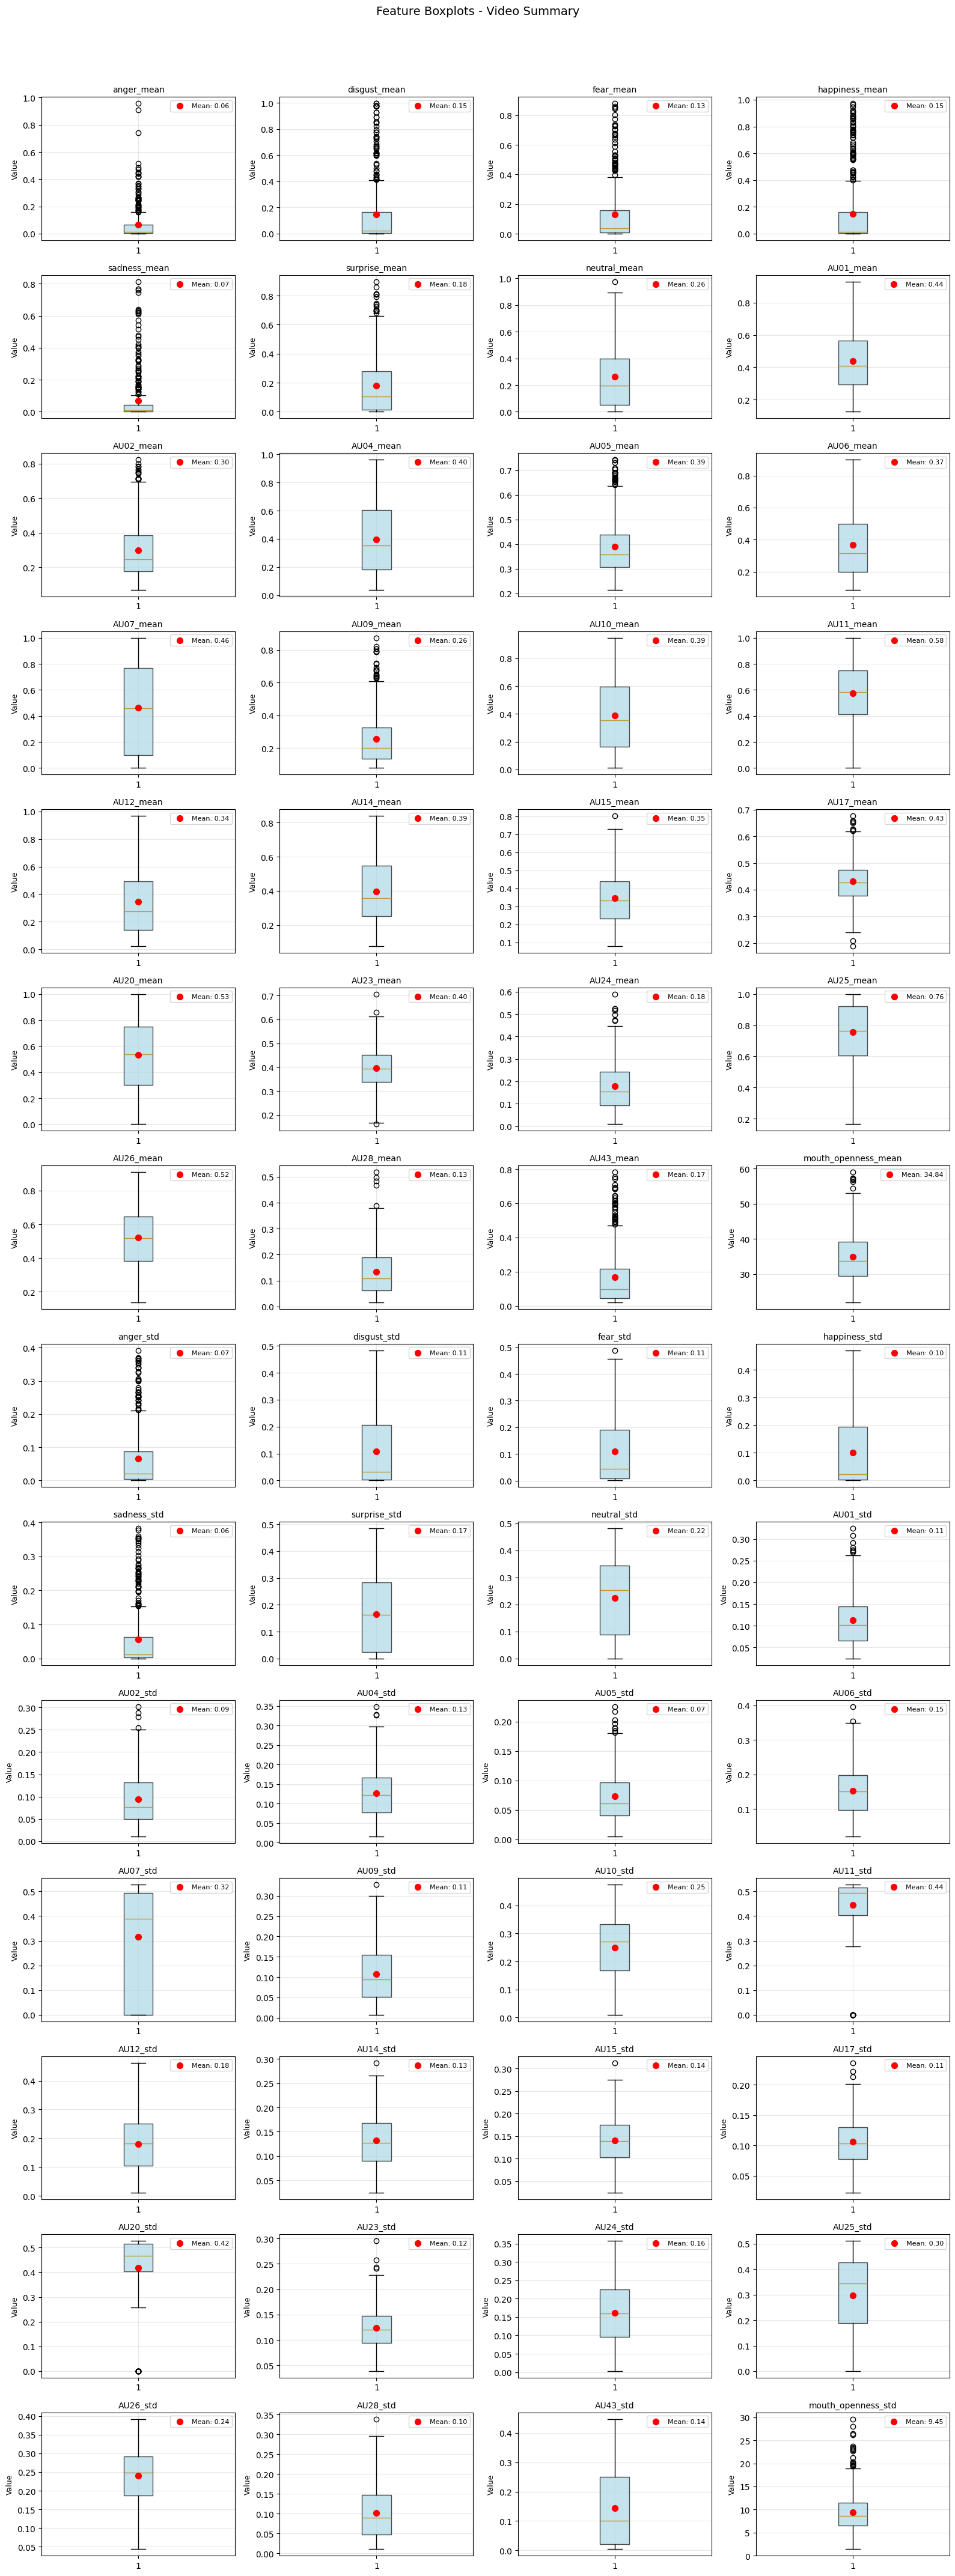

Showing 69 numeric features from Audio Summary


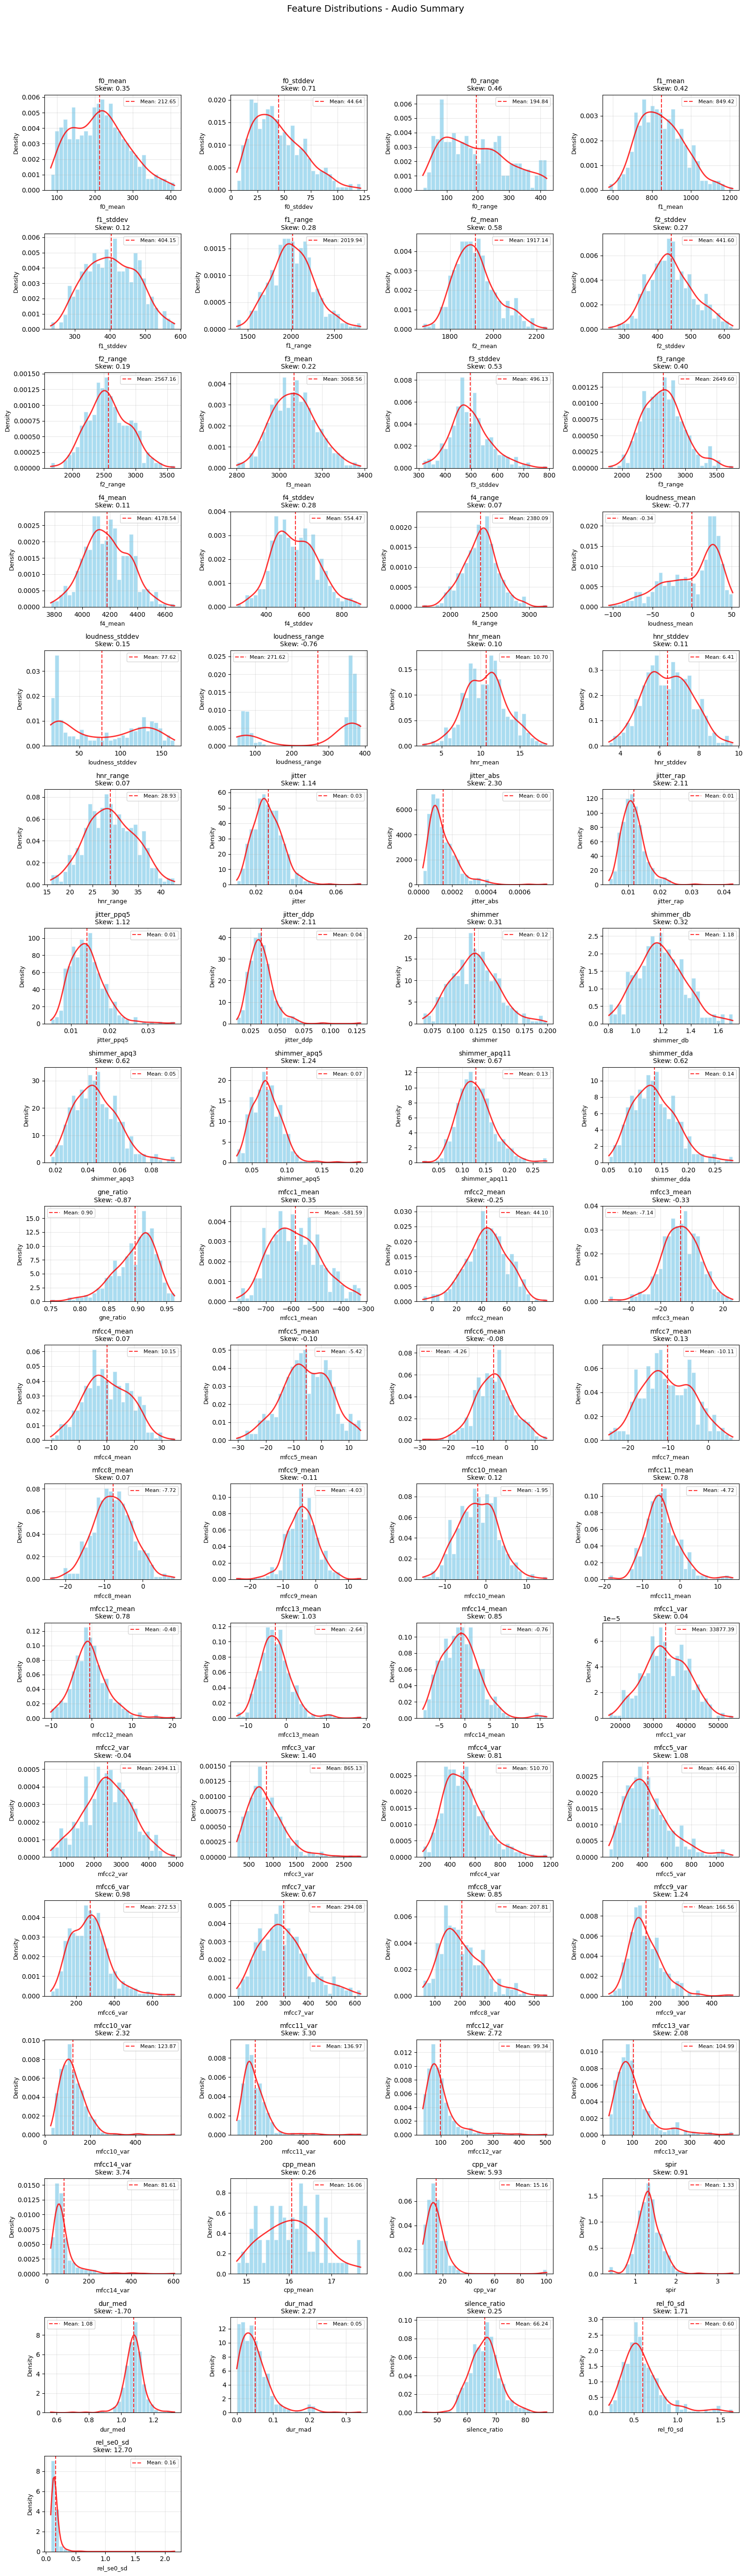

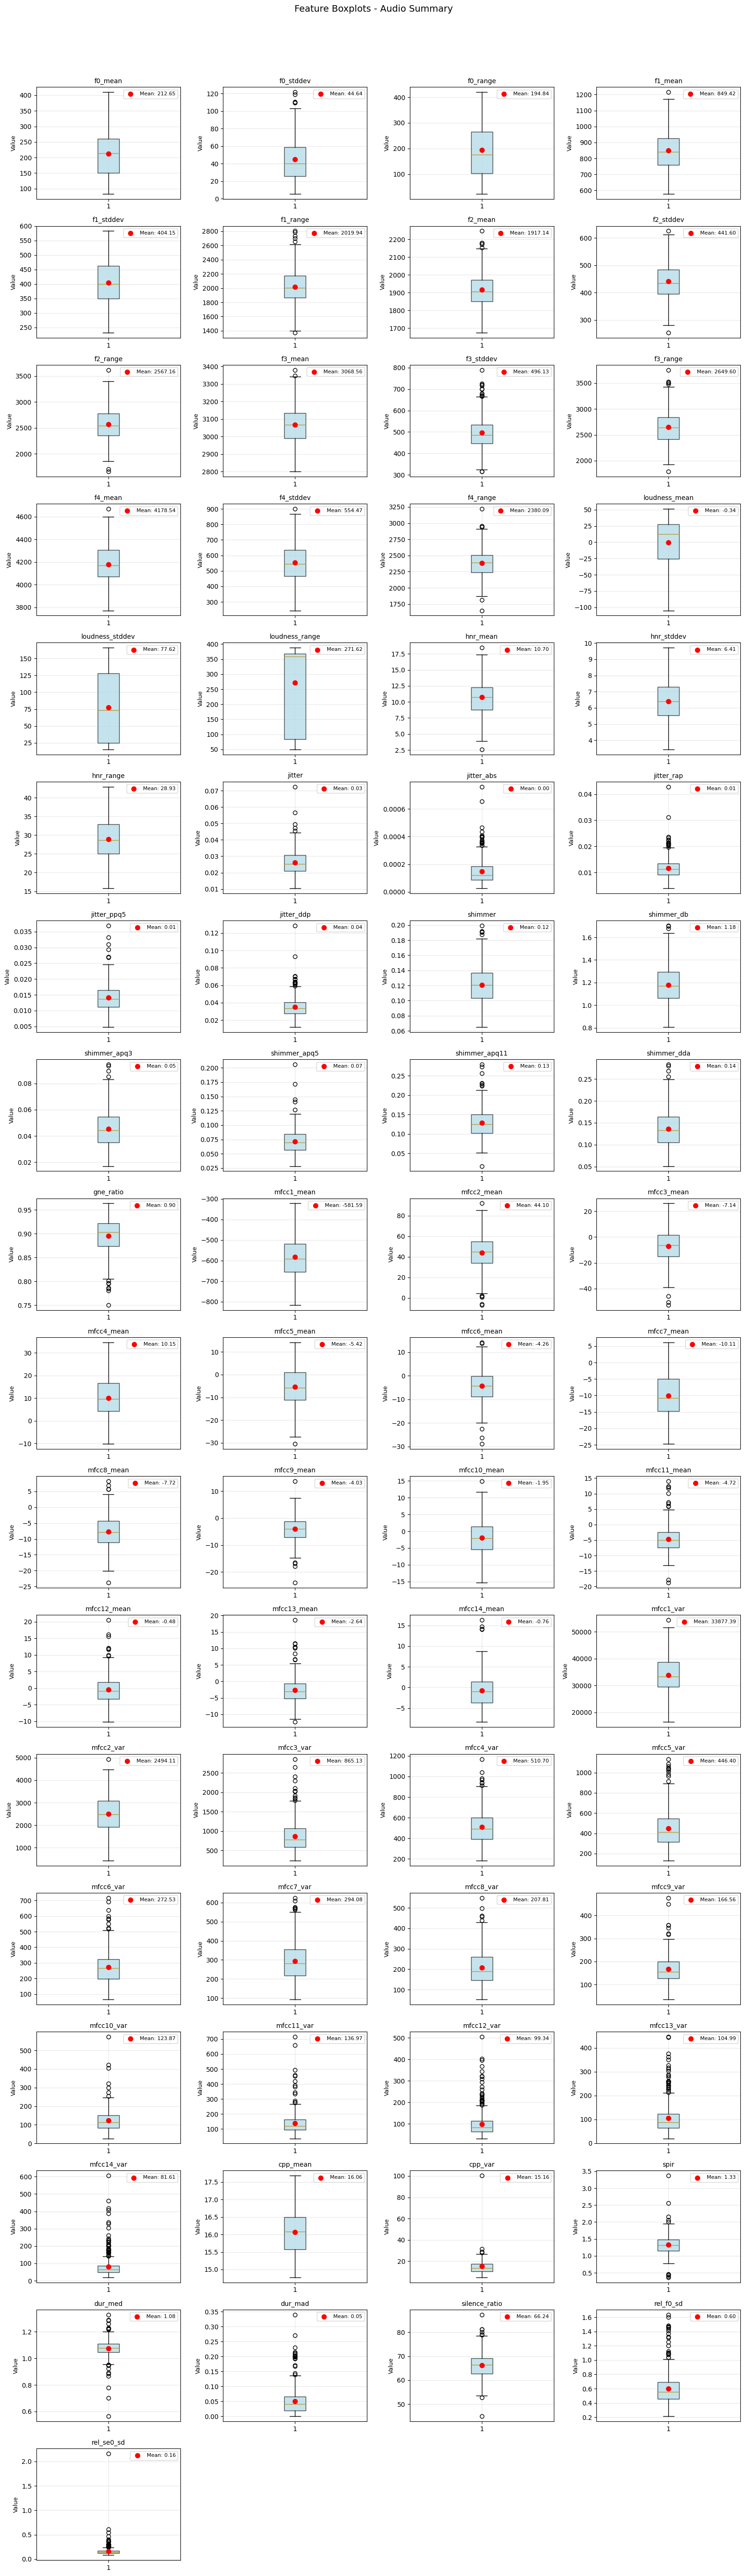

Showing 125 numeric features from Combined Summary


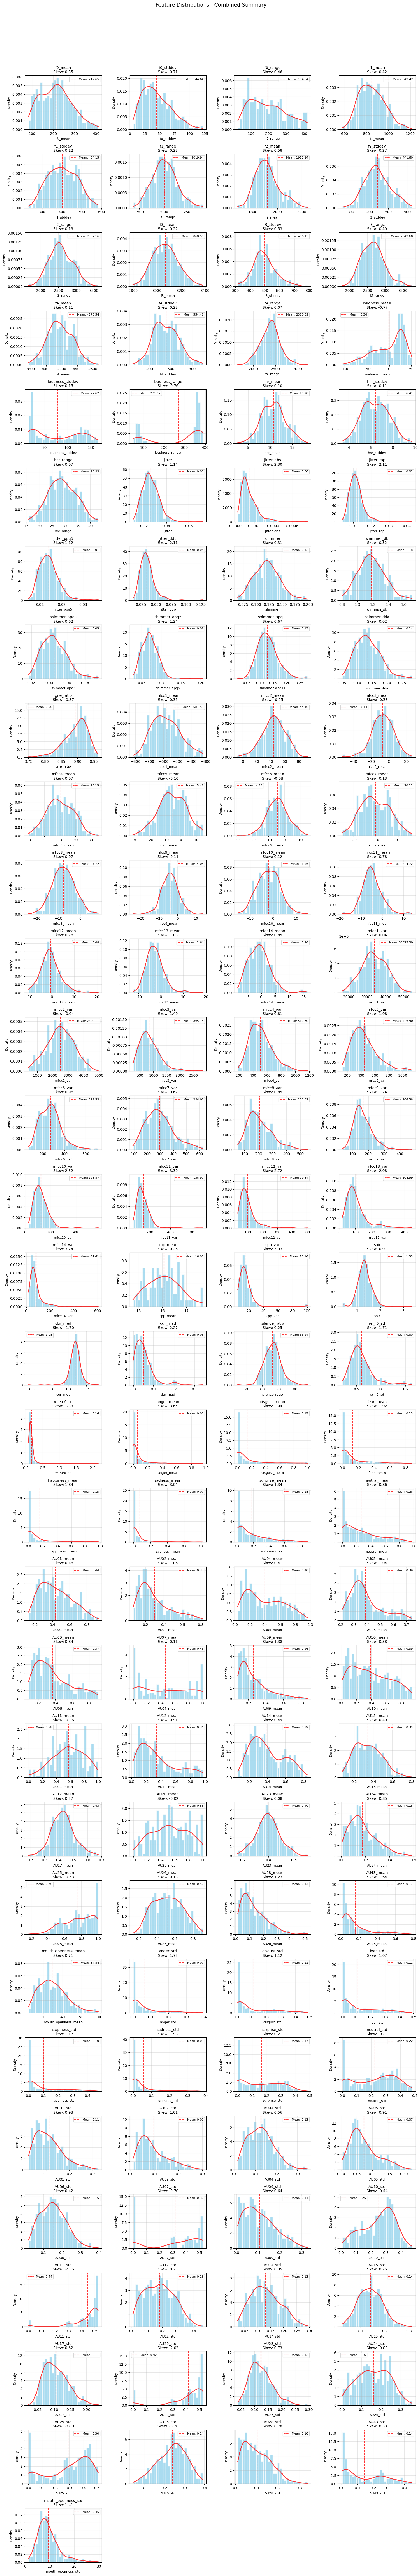

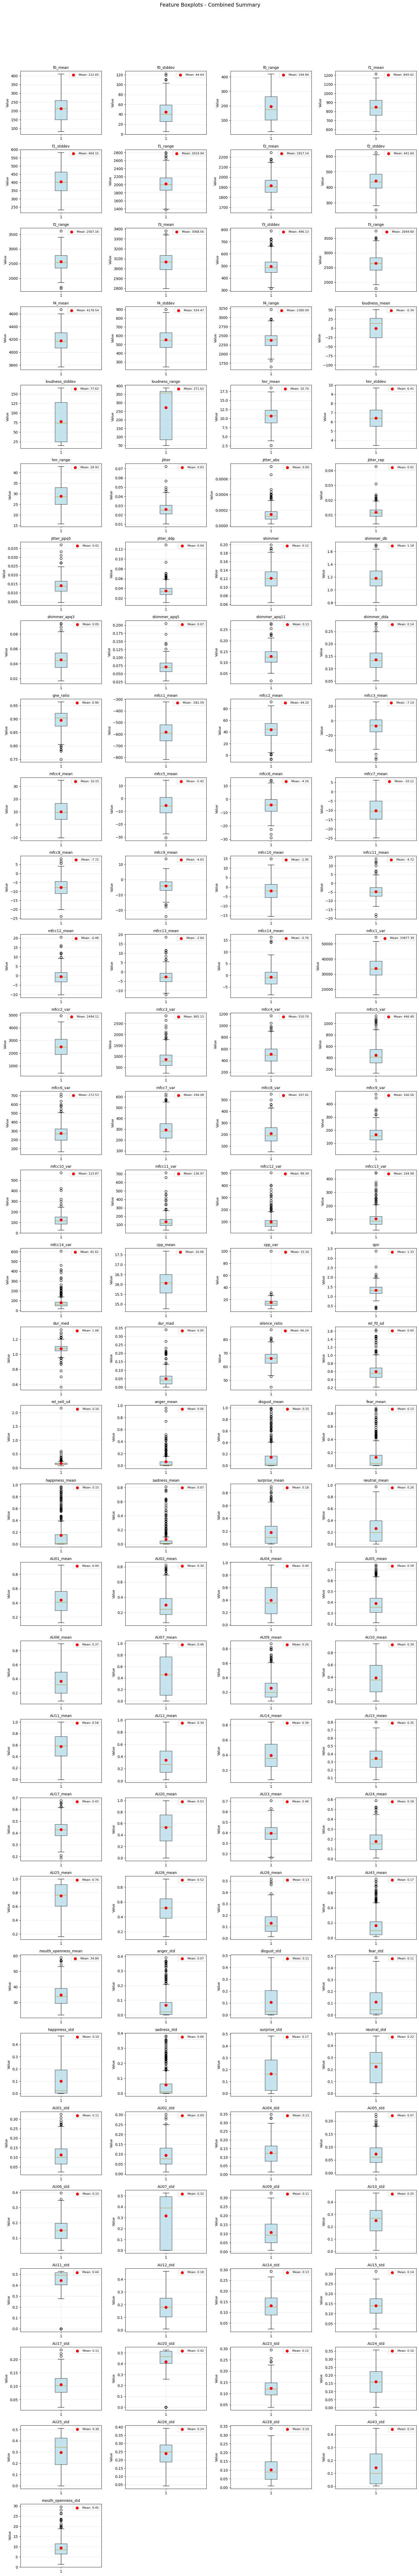

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)



# LOAD DATA

# Load dataframes from data directory
def load_datasets():
    datasets = {}
    files = {
        'video_summary': '../ravdess_processed_data/video_summary.csv',
        'audio_summary': '../ravdess_processed_data/audio_summary.csv',
        'combined_summary': '../ravdess_processed_data/combined_summary.csv'
    }
    
    for name, filename in files.items():
        try:
            datasets[name] = pd.read_csv(filename)
            print(f" Loaded {name}: {datasets[name].shape}")
        except FileNotFoundError:
            print(f" File not found: {filename}")
    
    return datasets

datasets = load_datasets()


# MISSING VALUES ANALYSIS

def analyze_missing(df, dataset_name):
    """Analyze missing values"""
    
    print(f"\n{'-'*20} {dataset_name.upper()} {'-'*20}")
    
    # Calculate missing values
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    
    # Create summary
    missing_summary = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': missing_count,
        'Missing_Percent': missing_percent.round(2)
    }).sort_values('Missing_Count', ascending=False)
    
    # Overall statistics
    total_missing = missing_count.sum()
    total_cells = df.shape[0] * df.shape[1]
    overall_rate = (total_missing / total_cells) * 100
    
    print(f"Dataset shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"Total missing values: {total_missing:,}")
    print(f"Overall missing rate: {overall_rate:.2f}%")
    print(f"Columns with missing values: {(missing_count > 0).sum()}")
    
    # Show ALL columns with missing values
    has_missing = missing_summary[missing_summary['Missing_Count'] > 0]
    if len(has_missing) > 0:
        print(f"\n Columns with missing values:")
        print(has_missing.to_string(index=False))
    else:
        print(" No missing values found!")
    
    return missing_summary


# FEATURE DISTRIBUTION ANALYSIS


def plot_feature_distributions(df, dataset_name):
    """Create distribution plots for numeric features"""
    
    # Select numeric columns (exclude metadata columns)
    exclude_cols = ['file', 'emotion', 'intensity', 'actor', 'gender']
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    if len(numeric_cols) == 0:
        print(f"No numeric features found in {dataset_name}")
        return
    
    print(f"Showing {len(numeric_cols)} numeric features from {dataset_name}")
    
    # Calculate grid size
    n_features = len(numeric_cols)
    n_cols = 4 if n_features > 9 else 3 if n_features > 4 else 2
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            # Clean data
            data = df[col].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(data) > 0:
                # Histogram with density curve
                axes[i].hist(data, bins=30, alpha=0.7, color='skyblue', 
                            density=True, edgecolor='white')
                
                # Add density curve
                try:
                    kde = stats.gaussian_kde(data)
                    x_range = np.linspace(data.min(), data.max(), 100)
                    axes[i].plot(x_range, kde(x_range), 'r-', linewidth=2, alpha=0.8)
                except:
                    pass
                
                # Add mean line
                mean_val = data.mean()
                axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, 
                               label=f'Mean: {mean_val:.2f}')
                
                # Statistics
                skew_val = data.skew()
                axes[i].set_title(f'{col}\nSkew: {skew_val:.2f}', fontsize=10)
                axes[i].set_xlabel(col, fontsize=9)
                axes[i].set_ylabel('Density', fontsize=9)
                axes[i].legend(fontsize=8)
                axes[i].grid(alpha=0.3)
            else:
                axes[i].text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                            transform=axes[i].transAxes)
                axes[i].set_title(f'{col} (No data)', fontsize=10)
    
    # Hide empty subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Feature Distributions - {dataset_name}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_boxplots(df, dataset_name):
    """Create boxplots for numeric features"""
    
    # Select numeric columns (exclude metadata columns)
    exclude_cols = ['file', 'emotion', 'intensity', 'actor', 'gender']
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    if len(numeric_cols) == 0:
        return
    
    # Create boxplots
    n_features = len(numeric_cols)
    n_cols = 4 if n_features > 9 else 3 if n_features > 4 else 2
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            # Clean data
            data = df[col].replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(data) > 0:
                # Boxplot
                box = axes[i].boxplot(data, patch_artist=True, 
                                     boxprops=dict(facecolor='lightblue', alpha=0.7))
                
                # Add mean point
                mean_val = data.mean()
                axes[i].scatter(1, mean_val, color='red', s=50, zorder=5, 
                               label=f'Mean: {mean_val:.2f}')
                
                axes[i].set_title(f'{col}', fontsize=10)
                axes[i].set_ylabel('Value', fontsize=9)
                axes[i].grid(alpha=0.3)
                axes[i].legend(fontsize=8)
            else:
                axes[i].text(0.5, 0.5, 'No valid data', ha='center', va='center', 
                            transform=axes[i].transAxes)
                axes[i].set_title(f'{col} (No data)', fontsize=10)
    
    # Hide empty subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle(f'Feature Boxplots - {dataset_name}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()





# ANALYZE ALL DATASETS


# Missing values analysis
missing_results = {}
for name, df in datasets.items():
    missing_results[name] = analyze_missing(df, name.replace('_', ' ').title())


print("\nSUMMARY TABLE")

summary_data = []
for name, df in datasets.items():
    total_missing = df.isnull().sum().sum()
    missing_rate = (total_missing / (df.shape[0] * df.shape[1])) * 100
    cols_with_missing = (df.isnull().sum() > 0).sum()
    numeric_features = len(df.select_dtypes(include=[np.number]).columns)
    
    summary_data.append({
        'Dataset': name.replace('_', ' ').title(),
        'Rows': df.shape[0],
        'Columns': df.shape[1],
        'Numeric_Features': numeric_features,
        'Missing_Values': total_missing,
        'Missing_Rate_%': round(missing_rate, 2),
        'Columns_with_Missing': cols_with_missing
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


# FEATURE DISTRIBUTION PLOTS

for name, df in datasets.items():
    
    # Distribution plots
    plot_feature_distributions(df, name.replace('_', ' ').title())
    
    # Boxplots
    plot_boxplots(df, name.replace('_', ' ').title())